# Classification of Normal Chest X-Rays from Pneumonic Chest X-Rays
## Final Project - Algorithms of Decision Making
### Author: Prabesh Paudel, May 16, 2020

Chest X-Rays are one of the most common ways of identifying if a patient has pneumonia. Even though doctors are very skilled at differentiating between normal chest X-rays and pneumonic X-rays, we cannot expect them to be correct all the time. This is one of the perfect areas where machine learning can be used. We can train our models using pre-identified images and use it to classify the x-rays with very high accuracy. 

The data I will be using is a data initially collected by Daniel Kermany, Kang Zhang, Michael Goldbaum. Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

This dataset has been studied a lot and a lot of paper have been published. Here I will try to use a couple of different algorithms to classify these images with highest accuracy possible. The state of the art Neural Networks have classified the data with 98.5% accuracy. I am not sure I will be able to get to 98.5% but I am very optimistic that we will get very close to it. 

Let's import required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

Let's create a function that will loop through out directory of dataset and create data for us. The images are all of variable sizes. Since training neural networks require a lot of computational power, we obviously cannot use the full resolution of the model. So, we will resize it into 128x128 images. We will also assign a target value to each one the images where:

* **0 = No pneumonia**
* **1 = Pneumonia**

*Note: I tried 256x256 as Prof. Richey suggested but it took ridiculously long time to train so it didn't seem like a viable option.*

In [2]:
data = []
IMG_SIZE = 128

DATADIR = "dataset"
CATEGORIES = ["normal", "pneumonia"]


def create_data():
    for category in CATEGORIES:  # do pneumonia and normal

        path = os.path.join(DATADIR,category)  # create path to normal and pneumonia
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=normal 1=pneumonia

        for img in tqdm(os.listdir(path)):  # iterate over each image per normal and pneumonia
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_data()

print(len(data))

100%|██████████| 1637/1637 [00:08<00:00, 198.02it/s]

3219


Let's shuffle the data so that the values will not be grouped together. 

In [3]:
import random
random.shuffle(data)

In [4]:
X = []
y = []

for features,label in data:
    X.append(features)
    y.append(label)

#Reshaping the data to fit the neural network
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

Let's look at a random image from the dataset to see what out re

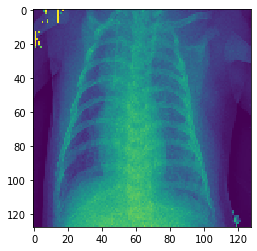

In [6]:
plt.imshow(data[random.randint(0, 199)][0])

Now, here comes the part where we design a neural network. Since **Convolutional Neural Networks** are very widely used for image recognition, we will be using CNN for this classification. I tried the regular Neural Network too but it didn't give us a similar accuracy. 

Let's import required libraries for building the model. 

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import datetime
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

We will be using TensorBoard to visualize the losses and accuracy so we need to clear cache and logs.

In [8]:
!rm -rf ./logs/ 

Let's scale the image so the pixel values will be between 0 and 1 and then separate it into train and testing data

In [9]:
X = X/255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Creating a tensorboard object

In [10]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [11]:
# Supressing warnings 
import warnings
warnings.filterwarnings('ignore')

#We are going to use a Sequential model from Keras
model = Sequential()

# Let's go with 256 filter and a convolutions of size 3x3
model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


W0517 10:09:27.269210 4483853760 deprecation.py:506] From /Users/prabesh/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0517 10:09:27.366185 4483853760 deprecation.py:323] From /Users/prabesh/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 256)     2560      
_________________________________________________________________
activation (Activation)      (None, 126, 126, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       590080    
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0

Let's fit the model using the training data

In [12]:
model.fit(x = X_train, 
          y = y_train, 
          epochs = 10, 
          validation_split = 0.1, 
          callbacks=[tensorboard])

Train on 2027 samples, validate on 226 samples
Epoch 1/10
2027/2027 [==============================] - 110s 54ms/sample - loss: 1.0031 - acc: 0.7676 - val_loss: 0.1938 - val_acc: 0.9204
Epoch 2/10
2027/2027 [==============================] - 110s 54ms/sample - loss: 0.1873 - acc: 0.9235 - val_loss: 0.1480 - val_acc: 0.9248
Epoch 3/10
2027/2027 [==============================] - 125s 62ms/sample - loss: 0.1806 - acc: 0.9339 - val_loss: 0.1276 - val_acc: 0.9425
Epoch 4/10
2027/2027 [==============================] - 127s 63ms/sample - loss: 0.1451 - acc: 0.9408 - val_loss: 0.1939 - val_acc: 0.9248
Epoch 5/10
2027/2027 [==============================] - 126s 62ms/sample - loss: 0.1246 - acc: 0.9521 - val_loss: 0.1383 - val_acc: 0.9513
Epoch 6/10
2027/2027 [==============================] - 125s 62ms/sample - loss: 0.1077 - acc: 0.9581 - val_loss: 0.1096 - val_acc: 0.9425
Epoch 7/10
2027/2027 [==============================] - 116s 57ms/sample - loss: 0.0822 - acc: 0.9674 - val_loss: 0.111

We get a training accuracy of 98.96% and a validation accuracy of 95.13% in the final epoch of the training. This is looking very good but this result has to translate in the test set too. 

Let's predict pneumonia or no pneumonia using the test set.

In [13]:
pred = model.predict(X_test)

Since the predict function does not give us 0 or 1 value but values that are very close to 0 or 1.So, let us create a function that will give out 1 if the value is close to 1 and 0 if it is close 0.

In [14]:
def assignValue(n):
    if n > 0.5:
        return 1
    else: 
        return 0

In [15]:
predictions_final = [assignValue(row) for row in pred]    

Let's look at the confusion matrix!

In [16]:
print(confusion_matrix(y_test, predictions_final))

[[408  40]
 [ 26 492]]


In [17]:
print(classification_report(y_test, predictions_final))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       448
           1       0.92      0.95      0.94       518

    accuracy                           0.93       966
   macro avg       0.93      0.93      0.93       966
weighted avg       0.93      0.93      0.93       966



This is interesting! We achieved an accuracy of 94% which I think is pretty good. But for No pneumonia, the precision is 0.91 and for pneumonia, precision is 0.96. So, out model is better at finding pneumonic case. We would rather have high precision for pneumonia because we would not want to classify someone with pneumonia as someone who doesn't have pneumonia because it could very well jeopardize somebody's life. 

Let's look at Tensorboard to see how out losses and accuracy changed as the epochs went through. 

In [18]:
%load_ext tensorboard
%tensorboard --logdir logs/

## Singular Value Decomposition

In [19]:
from sklearn.utils.extmath import randomized_svd
U, D, V = np.linalg.svd(X)

In [20]:
U.shape

(3219, 128, 128, 128)

In [21]:
D.shape

(3219, 128, 1)

In [22]:
V.shape

(3219, 128, 1, 1)

In [23]:
data[0][0]

array([[ 61,  21,  31, ..., 120, 184, 255],
       [ 56,  31,  38, ..., 120, 135, 244],
       [ 69,  50,  42, ...,  78, 115, 232],
       ...,
       [  0,   2,  38, ...,   0,   0,   0],
       [  0,  14,  42, ...,   0,   0,   0],
       [  0,  28,  35, ...,   0,   0,   0]], dtype=uint8)

In [24]:
X[0][0].shape

(128, 1)

In [25]:
f, l = data[0]

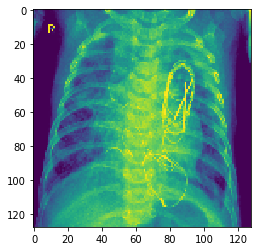

In [26]:
plt.imshow(f)

In [27]:
X.shape

(3219, 128, 128, 1)

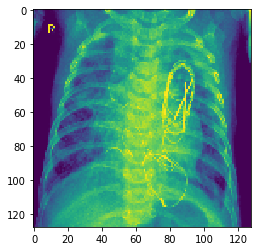

In [28]:
plt.imshow(np.array(f).reshape(-1, 128, 128, 1).reshape(128, 128))

In [29]:
f.shape

(128, 128)

In [30]:
X_temp = np.array(X).reshape(len(X), IMG_SIZE, IMG_SIZE)

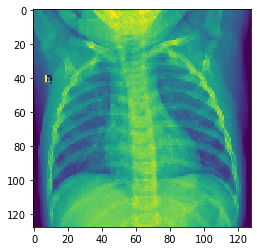

In [31]:
plt.imshow(X_temp[234])

In [32]:
U, D, V = np.linalg.svd(X_temp)

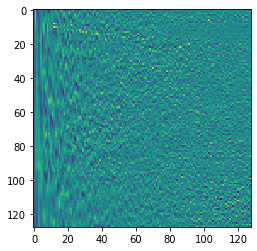

In [33]:
plt.imshow(U[1])

We looked at SVD also, but we lost a lot of features so it was virtually impossible to reconstruct. So we will look at a different algorithm to contrast the neural network with!

## K-Nearest Neighbors

K-Nearest Neighbors is another very widely used algorithm. Even though it is not very widely used for image classification, we could give it a shot and see what kind of a result we get.

In [34]:
X_new = np.array(X).reshape(len(X), IMG_SIZE * IMG_SIZE)/255

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

#Let's use k = 3 and see how this will work.
knn = KNeighborsClassifier(n_neighbors=3)

In [37]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [38]:
prediction = knn.predict(X_test)

In [39]:
np.mean(prediction == y_test)

0.9037267080745341

90.37 % accuracy! I really did not expect kNN to do this well in image classification. Let's build a function that will give us the accuracy.

In [40]:
def getKNNAccuracy(n):
    knn = KNeighborsClassifier(n_neighbors=3)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3)
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    return np.mean(prediction == y_test)

Let's check if the function works!

In [41]:
getKNNAccuracy(4)

0.8954451345755694

Now let's get this for a bunch of k values!

In [42]:
knn_accuracy = [getKNNAccuracy(k) for k in range(1, 10)]

Text(0.5, 1.0, 'kVal vs. Accuracy Graph!')

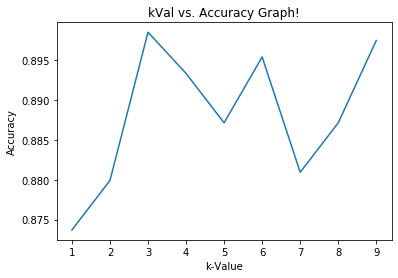

In [44]:
plt.plot(range(1, 10), knn_accuracy)
plt.xlabel("k-Value")
plt.ylabel("Accuracy")
plt.title("kVal vs. Accuracy Graph!")

Looks like the accuracy is all over the place but overall the accuracy stays above 87% the entire time. I think kNN might be a good algorithm to classify these images.

## Final Thoughts

As simple as kNN is and as fast as it is, with the advent of modern computers and GPU with thousands of cores in them, Neural Networks are getting easier to train. I think the extra training time and computational power is worth 5% accuracy. Hence the popularity of Neural Networks in the apst decade. We were able to increase the accuracy with just a little effort. Imagine what could be done with years of research. We all know the increase in accuracy is a diminishing return even a 0.1 increase in accuracy can be worth a lot when we apply these model to a large population.